# Exploratory Data Analysis

Exploratory data analysis is to explore and summarize the main characteristics of data sets.
This notebook analyze the data set from the following aspects:

1. Basic information of the dataset.

2. The trend of sales.

3. The correlation between sales and numerical variables.

4. The distribution of numerical variables.

5. The correlation between sales and categorical/discrete variables.

6. The cardinality of categorical variables.

7. The correlation between different dependent variables

In [1]:
import pandas as pd
import numpy as np

# libiaries for visualization
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.pipeline import Pipeline

# for feature engineering
from feature_engine import imputation as mdi

# for calculating significance
from scipy import stats

In [2]:
# set directory
output_dir = "../../outputs/"
data_dir = "../data/"

## Data Loading

In [3]:
training_set = pd.read_csv(data_dir + "train.csv")
test_set = pd.read_csv(data_dir + "test.csv")
sample_set = pd.read_csv(data_dir + "sample.csv", header=None) #check the header

## Basic Information Exploration 

First, let's have a quick look at the dataset.

In [4]:
training_set

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1
...,...,...,...,...,...,...,...,...,...,...,...,...
202,2014-9-24,59,水,1,白身魚のマスタード焼き,408.0,NaN,NaN,NaN,曇,0,24.8
203,2014-9-25,50,木,0,牛カルビ焼き肉,394.0,NaN,NaN,NaN,曇,0,25.4
204,2014-9-26,45,金,0,ランチビュッフェ,NaN,スペシャルメニュー（800円）,キャリアアップ支援セミナー,NaN,晴れ,--,27.1
205,2014-9-29,56,月,1,豚肉と玉子の炒め,404.0,NaN,NaN,NaN,快晴,--,26.6


In [5]:
# print basic attributes of the dataset
var_list = [var for var in training_set.columns if var != "y"]
print("The number of independent variables: %d, \nwhich are" % (len(var_list)))
print(var_list)

print("\n"
     "The number of training items: %d\n"
     "The number of test items: %d" % (len(training_set), len(test_set)))

The number of independent variables: 11, 
which are
['datetime', 'week', 'soldout', 'name', 'kcal', 'remarks', 'event', 'payday', 'weather', 'precipitation', 'temperature']

The number of training items: 207
The number of test items: 40


In [6]:
# Insights about the dataset
training_set.dtypes

datetime          object
y                  int64
week              object
soldout            int64
name              object
kcal             float64
remarks           object
event             object
payday           float64
weather           object
precipitation     object
temperature      float64
dtype: object

In [7]:
training_set.describe(include="all")

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
count,207,207.000000,207,207.000000,207,166.000000,21,14,10.0,207,207,207.000000
unique,207,NaN,5,NaN,156,NaN,6,2,NaN,7,8,NaN
top,2014-4-17,NaN,水,NaN,メンチカツ,NaN,お楽しみメニュー,ママの会,NaN,快晴,--,NaN
freq,1,NaN,43,NaN,6,NaN,12,9,NaN,53,169,NaN
mean,NaN,86.623188,NaN,0.449275,NaN,404.409639,NaN,NaN,1.0,NaN,NaN,19.252174
std,NaN,32.882448,NaN,0.498626,NaN,29.884641,NaN,NaN,0.0,NaN,NaN,8.611365
min,NaN,29.000000,NaN,0.000000,NaN,315.000000,NaN,NaN,1.0,NaN,NaN,1.200000
25%,NaN,57.000000,NaN,0.000000,NaN,386.000000,NaN,NaN,1.0,NaN,NaN,11.550000
50%,NaN,78.000000,NaN,0.000000,NaN,408.500000,NaN,NaN,1.0,NaN,NaN,19.800000
75%,NaN,113.000000,NaN,1.000000,NaN,426.000000,NaN,NaN,1.0,NaN,NaN,26.100000


We can find that our dataset contains 207 training samples and 40 test samples in total.
There are 11 independent variables and 1 dependent variable ```y``` which stands for the sales of the boxed lunch.
Variables are a mixture of numerical, categorical and datetime types.
Independent variables are related to the time/date, the menu, same special events, or the weather.

### Check the time span
Since our dataset is related to the date time, we first explore the time span that the data covers.

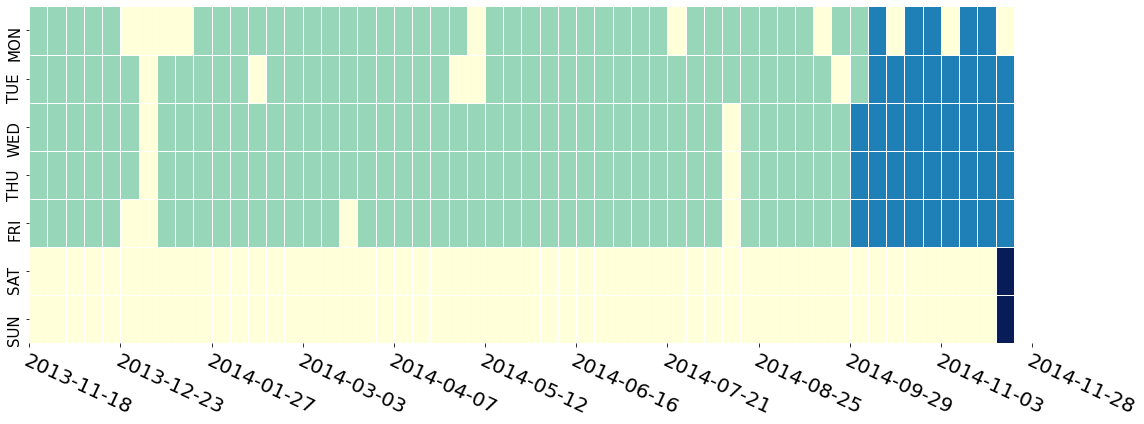

In [8]:
# Convert the ```datetime``` into a indication map.
# The value of each location in the map indicates if a date is with a training sample (=1),
# with a test sample (=2), or without any data(=0)
train_date = pd.to_datetime(training_set.datetime)
test_date = pd.to_datetime(test_set.datetime)
visualization_range = pd.date_range(start=train_date.min(), end=test_date.max())
date_label = np.zeros(len(visualization_range),)
idx = 0
for date in np.array(visualization_range):
    if date in np.array(train_date):
            date_label[idx] = 1      # train label
    elif date in np.array(test_date):
            date_label[idx] = 2      # test label
    idx += 1   
days = (test_date.max() - train_date.min()).days + 1
date_label = np.concatenate((date_label, 3*np.ones((days//7+1)*7-days)))

# Visualize the indication map
fig, ax = plt.subplots(figsize=(16, 6)) #Compared to plt.figure, the plt.subplots() object will act as a more automatic axis manager, without call fig.add_axes
sns.heatmap(date_label.reshape((-1,7)).transpose(), linewidths=.5, cbar=False, cmap="YlGnBu",ax=ax)
week = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

step_show = 5
date = list(visualization_range.strftime('%Y-%m-%d')[0:-1:7*step_show]) + [visualization_range.strftime('%Y-%m-%d')[-1]]
ax.set_xticks(np.arange(0,len(date)*step_show,step_show))
ax.set_xticklabels(date, fontdict={'fontsize':20})
ax.set_yticklabels(week, fontdict={'fontsize':15})
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-25, ha="left",
         rotation_mode="anchor")
fig.tight_layout()
#plt.show()
# Save the figure
#fig.savefig(output_dir + "datetime_distribution.eps")

Training samples are collcted from November in 2013 to September in 2014. 
Test samples follow the training samples.
This is no data in weekend and in holidays.

### Check missing values

[Text(0, 0.5, 'datetime'),
 Text(0, 1.5, 'y'),
 Text(0, 2.5, 'week'),
 Text(0, 3.5, 'soldout'),
 Text(0, 4.5, 'name'),
 Text(0, 5.5, 'kcal'),
 Text(0, 6.5, 'remarks'),
 Text(0, 7.5, 'event'),
 Text(0, 8.5, 'payday'),
 Text(0, 9.5, 'weather'),
 Text(0, 10.5, 'precipitation'),
 Text(0, 11.5, 'temperature')]

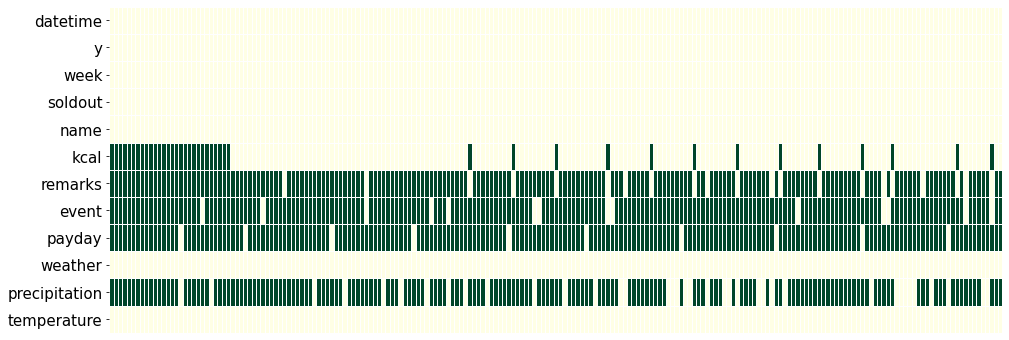

In [17]:
# Construct a indication map for missing positions.
nan_label = (training_set.isnull()) |(training_set=='--') 
vars_with_na = [var for var in nan_label.columns if nan_label[var].sum() > 0]

# visualize the indication map 
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(nan_label.T, ax=ax, cbar=False, cmap="YlGn", linewidths=.7)
ax.set_xticks([])
ax.set_yticklabels(training_set.columns, fontdict={'fontsize':15})
# save the figure
#fig.savefig(output_dir + "nan_valus.eps")

There are missing values in ```kcal```, ```remarks```, ```event```, ```payday```, and ```precipitation```.

## The trend of sales
Next, let's have an overall look at the trend of sales.

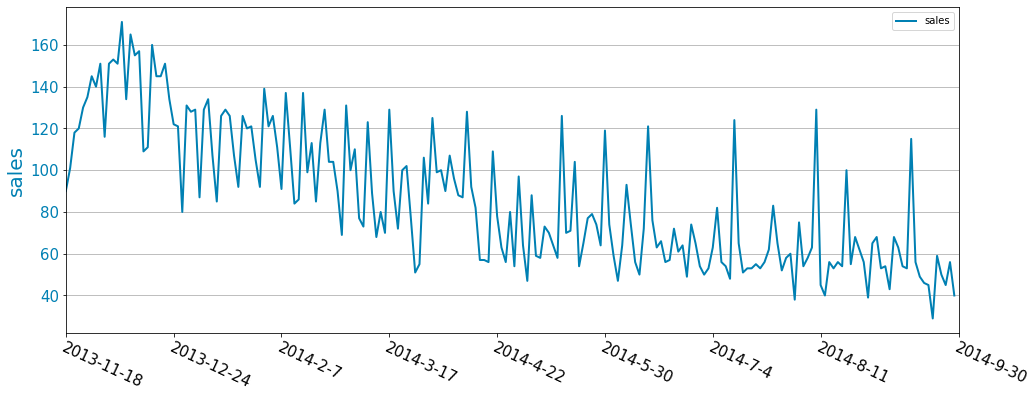

In [20]:
## check the trend of y w.r.t datetime
color_y = [0,0.5,0.7]
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(training_set['datetime'], training_set['y'], color=color_y, linewidth=2, label='sales')
ax.set_ylabel('sales', fontsize=20, color=color_y)
ax.grid(axis='y')
#show legend
ax.legend()
# Set xtick labels
step_show = 5 * 5
date = training_set['datetime'][0:-1:step_show].values.copy()
date[-1] = training_set.iloc[-1,0]
xticks = np.arange(0,len(training_set),step_show)
xticks[-1] = len(training_set)
ax.set_xticks(xticks)
ax.set_xticklabels(date)
ax.set_xlim(0, len(training_set))
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-25, ha="left",
         rotation_mode="anchor")
ax.tick_params(labelsize=15)
ax.tick_params('y', labelcolor=color_y)
# Save the figure
# fig.savefig(output_dir + "y_trend.eps")

Sales were on a downward trend during the period of record.
Since temperature is related to the datetime, we plot the temperature and sales at the same time.

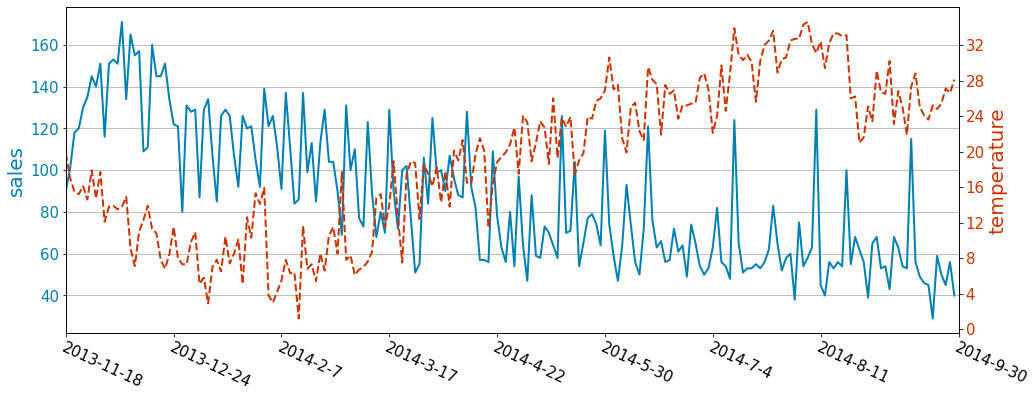

In [21]:
## Check the trend of y with temperature
color_y = [0,0.5,0.7]
color_t = [0.8,0.2,0]

# Plot the curve of sales 
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(training_set['datetime'], training_set['y'], color=color_y, linewidth=2, label='sales')
ax.set_ylabel('sales', fontsize=20, color=color_y)
ax.grid(axis='y')

# Plot the curve of temperature 
ax2 = plt.twinx()
ax2.plot(training_set['datetime'], training_set['temperature'], color=color_t,  linestyle='--', linewidth=2, label='temperature')

ax2.grid(False)
ax2.set_ylabel('temperature', fontsize=20, color=color_t)
ax2.set_yticks(np.arange(0, training_set['temperature'].max(), training_set['temperature'].max()//8).tolist())
ax2.tick_params('y', labelsize=15, labelcolor=color_t)

# Show legend
# ax2.legend()
# Set xtick labels
step_show = 5 * 5
date = training_set['datetime'][0:-1:step_show].values.copy()
date[-1] = training_set.iloc[-1,0]
xticks = np.arange(0,len(training_set),step_show)
xticks[-1] = len(training_set)
ax.set_xticks(xticks)
ax.set_xticklabels(date)
ax.set_xlim(0, len(training_set))
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-25, ha="left",
         rotation_mode="anchor")
ax.tick_params(labelsize=15)
ax.tick_params('y', labelcolor=color_y)

# Save the figure
#fig.savefig(output_dir + "y_t_trend.eps")

When the temperature rises, sales drop.
We can also observe that the curve is not changing smoothly.
There are spikes on the curve.
To find the causation of spikes, we mark ```event```, ```remarks```, and ```payday``` on the curve.

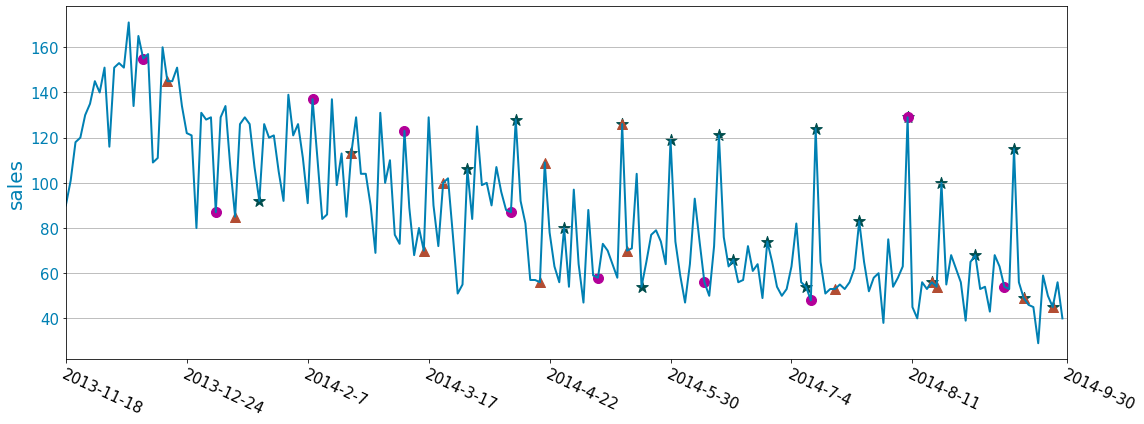

In [22]:
## Check y with remarks, events, and payday
color_y = [0, 0.5, 0.7]
color_r = [0, 0.3, 0.3]
color_e = [0.7, 0.3, 0.2]
color_p = [0.7, 0.0, 0.6]
# Plot the curve of sales
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(training_set['datetime'], training_set['y'], color=color_y, linewidth=2, label='sales')
ax.set_ylabel('sales', fontsize=20, color=color_y)
ax.grid(axis='y')
#show legend
#ax.legend()
# Set xtick labels
step_show = 5 * 5
date = training_set['datetime'][0:-1:step_show].values.copy()
date[-1] = training_set.iloc[-1,0]
xticks = np.arange(0,len(training_set), step_show)
xticks[-1] = len(training_set)
ax.set_xticks(xticks)
ax.set_xticklabels(date)
ax.set_xlim(0, len(training_set))
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-25, ha="left",
         rotation_mode="anchor")
ax.tick_params(labelsize=15)
ax.tick_params('y', labelcolor=color_y)

# Mark remarks
data_with_remarks = training_set[['datetime','y']][training_set['remarks'].notnull()]
ax.scatter(data_with_remarks['datetime'], data_with_remarks['y'], 150, color=color_r, marker='*')

# Mark event
data_with_remarks = training_set[['datetime','y']][training_set['event'].notnull()]
ax.scatter(data_with_remarks['datetime'], data_with_remarks['y'], 100, color=color_e, marker='^')

# Mark payday

data_with_remarks = training_set[['datetime','y']][training_set['payday'].notnull()]
ax.scatter(data_with_remarks['datetime'], data_with_remarks['y'], 100, color=color_p, marker='o')

fig.tight_layout()
# Save the figure
#fig.savefig(output_dir + "y_rmk_trend.eps")

We can observe that sales can be affected by events and menus.

## The Correaltions between Sales and Numeric Variables
Let's first compute the correlation coefficient between sales and the numerical variables ```temperature``` and ```kcal```.

In [23]:
training_set[['y', 'temperature', 'kcal']].corr()

,y,temperature,kcal
y,1.000000,-0.655332,0.147269
temperature,-0.655332,1.000000,-0.046191
kcal,0.147269,-0.046191,1.000000


To visualize the correlation between sales and these two numerical variables, we scatter the data points and fit a line to these points.

Text(0.5, 0, 'temperature')

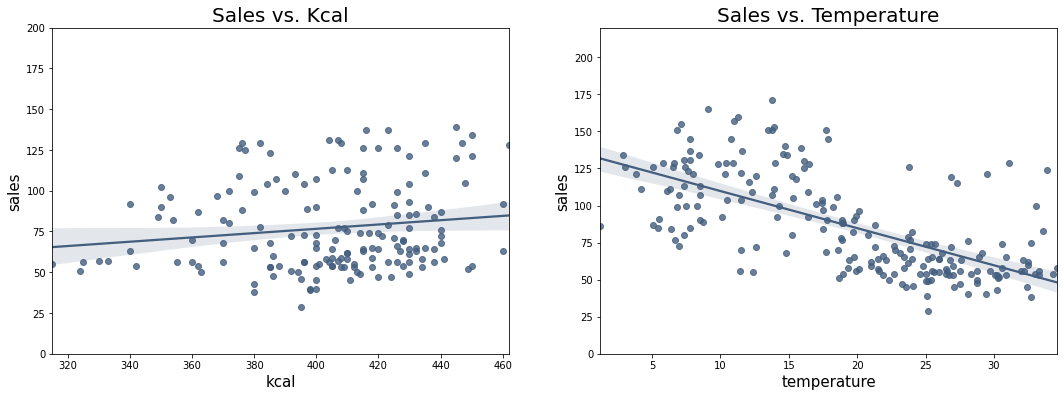

In [26]:
## Visualising correlation between sales and two numerical variables
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
color = [68/255,94/255,126/255]
# Scatter plot kcal data
sns.regplot(data=training_set, x="kcal", y="y", ax=axes[0], color=color)
axes[0].set_title("Sales vs. Kcal", fontdict={'fontsize':20})
axes[0].set_ylim(0, 200)
axes[0].set_ylabel('sales', fontsize=15)
axes[0].set_xlabel('kcal', fontsize=15)
# Scatter plot temperature data
sns.regplot(data=training_set, x="temperature", y="y", ax=axes[1], color=color)
axes[1].set_title("Sales vs. Temperature", fontdict={'fontsize':20})
axes[1].set_ylim(0,220)
axes[1].set_ylabel('sales', fontsize=15)
axes[1].set_xlabel('temperature', fontsize=15)
# Save figure
#fig.savefig(output_dir + "sales_corrs.eps")

We can observe a negative  correlation between salese and temperature.

We would also like to know P-value which tells us whether the correlation is significant or not.

We choose a significance level $\alpha$ of 0.05:

- p-value < 0.001: strong evidence that the correlation is significant,
- p-value < 0.05: moderate evidence that the correlation is significant,
- p-value < 0.1: weak evidence that the correlation is significant, and
- p-value > 0.1: no evidence that the correlation is significant.


In [27]:
data= training_set[['kcal', 'y']].dropna()
pearson_coef, p_value = stats.pearsonr(data['kcal'], data['y'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.14726872261239105  with a P-value of P = 0.05830146995967055


In [28]:
pearson_coef, p_value = stats.pearsonr(training_set['temperature'], training_set['y'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.655332191731349  with a P-value of P = 8.823292969373572e-27


We can find that there is weak evidence that ```sales``` is correlated to ```kcal```; while the negative correlation between ```sales``` and ```temperature``` is statistically significant, which is coincident with what we have found in the sale-temperature curves.

## Distribution of Numerical Variables
Some machine learning models like linear and logistic regression assume that the variables are normally distributed.
So we next check the distribution of numerical variables.

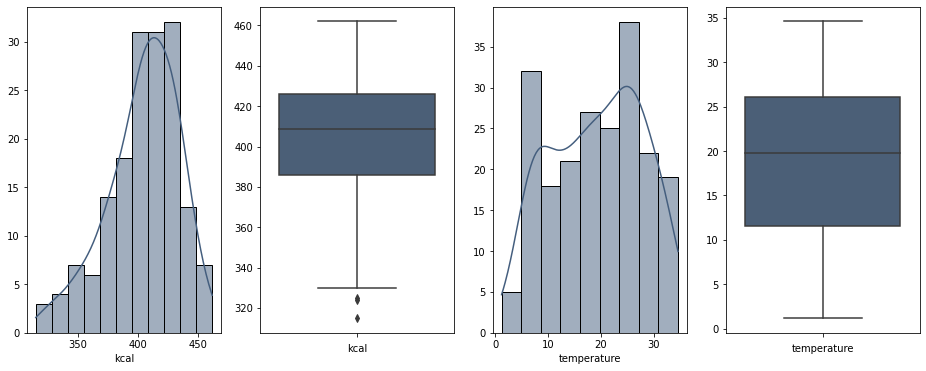

In [29]:
# Visualize the distributions of numerical variables
# Check the distribution of kcal
color = [68/255, 94/255, 126/255]
numerical = ['kcal', 'temperature']
fig, ax = plt.subplots(1, 4, figsize=(16,6))
i = 0
for var in numerical:
    sns.histplot(data=training_set, x=var, kde=True, ax=ax[2*i], color=color)
    sns.boxplot(y=var, data=training_set, ax=ax[2*i + 1], orient='v', color=color)
    ax[2*i].set_ylabel('', fontsize=10)
    ax[2*i + 1].set_ylabel('', fontsize=10)
    ax[2*i+1].set_xlabel(var, fontsize=10)
    ax[2*i].set_xlabel(var, fontsize=10)
    i += 1

# Save the figure
# fig.savefig(output_dir + "kcal_temperature_dis.eps")

We can find ```temperature``` is not normally distrubed, and there are outliers and skewness in ```kcal```. 

## The Correlation between Sales and Categorical/Discrete Variables

Before we explore the relationship between sales and categorical variables, we need to preprocess the categorical variables.

In [30]:
# Extract month from ```datetime``` 
training_set['month'] = pd.to_datetime(training_set.datetime).dt.month

In [31]:
# Impute the missing values in ```payday```
training_set['payday'] = training_set['payday']==1
training_set['payday'] = training_set['payday'].astype('O')

In [32]:
## Impute the missing values in ```weather```, ```remarks```, and ```event```
mdi_pipe = Pipeline([
    ('imputer_cat', mdi.CategoricalImputer(fill_value='N/A', 
                                           variables=['weather', 'remarks', 'event'])),
    
])

training_set = mdi_pipe.fit_transform(training_set)

### Correlation between sales and time-related variables

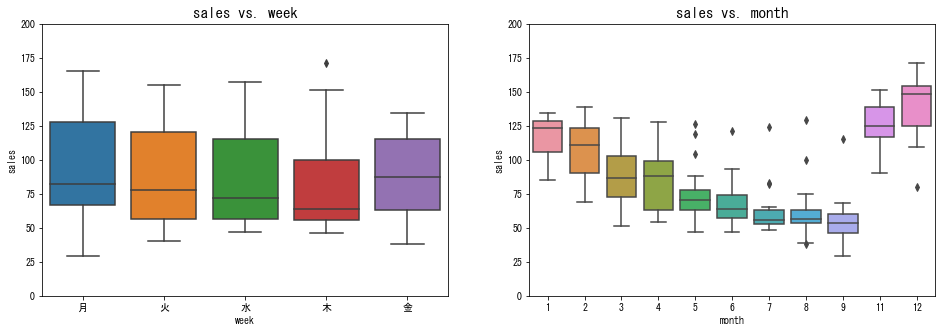

In [54]:
# Visualize time-related by using boxplots
plt.rcParams['font.family'] = 'MS Gothic'#Enable Japanese font
variables = ['week', 'month']
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
i = 0
for var in variables:
    sns.boxplot(x=var, y="y", data=training_set,ax=ax[i])
    ax[i].set_title("sales vs. " + var, fontdict={'fontsize':15})
    ax[i].set_ylim(0,200)
    ax[i].set_ylabel('sales', fontsize=10)
    ax[i].set_xlabel(var, fontsize=10)
    i = i+1

# Save figures
#fig.savefig(output_dir + "sales_date.eps")


We can observe that there is notable overlap between the sales of different week days, so it will not be a suitbale predictor.
On the contrary, the sales of different month is distinguishable, so the date time canbe a very promissing indicator.

### Correlation between sales and weather-related variables

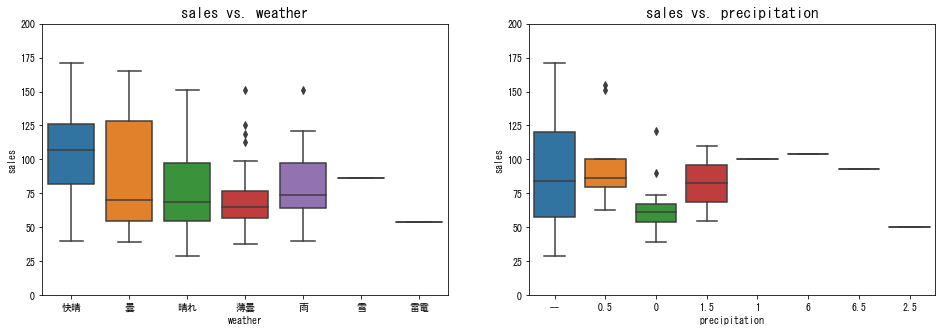

In [53]:
# Visualize weather-related by using boxplots
plt.rcParams['font.family'] = 'MS Gothic'#IPAexGothic
variables = ['weather', 'precipitation']
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
i = 0
for var in variables:
    sns.boxplot(x=var, y="y", data=training_set,ax=ax[i])
    ax[i].set_title("sales vs. " + var, fontdict={'fontsize':15})
    ax[i].set_ylim(0, 200)
    ax[i].set_ylabel('sales', fontsize=10)
    ax[i].set_xlabel(var, fontsize=10)
    i = i+1

# Save figures
# fig.savefig(output_dir + "sales_weather.eps")

We can observe the overlap between the sales of different weather/precipitation.

### Correlation between sales and event/menu-related variables

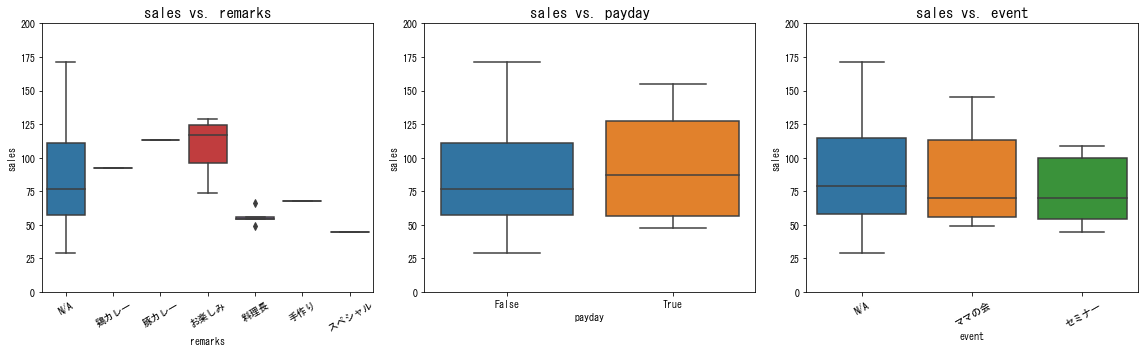

In [52]:
# Rename the caregories of remarks
training_set.replace({'event': {'キャリアアップ支援セミナー': 'セミナー'},
                      'remarks': {'鶏のレモンペッパー焼（50食）、カレー（42食）': '鶏カレー',
                                  '酢豚（28食）、カレー（85食）': '豚カレー',
                                  'お楽しみメニュー':'お楽しみ',
                                  '料理長のこだわりメニュー':'料理長',
                                  '手作りの味':'手作り',
                                  'スペシャルメニュー（800円）':'スペシャル'}}, inplace=True)

# Visualize menu/event-related by using boxplots
plt.rcParams['font.family'] = 'MS Gothic'#IPAexGothic
variables = ['remarks', 'payday', 'event']
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
i = 0
for var in variables:
    sns.boxplot(x=var, y="y", data=training_set,ax=ax[i])
    ax[i].set_title("sales vs. " + var, fontdict={'fontsize':15})
    ax[i].set_ylim(0, 200)
    ax[i].set_ylabel('sales', fontsize=10)
    ax[i].set_xlabel(var, fontsize=10)
    i = i+1

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30)
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=30)

plt.tight_layout()

# Save figures
# fig.savefig(output_dir + "sales_event.eps")


The sales of the お楽しみメニュー　is distinguishable, so remarks can potentially be an indicator.


## Number of labels: cardinality
Performance of models may be affected by high cardinality. Let's go ahead now and examine the cardinality of our categorical variables. That is, the number of different labels.

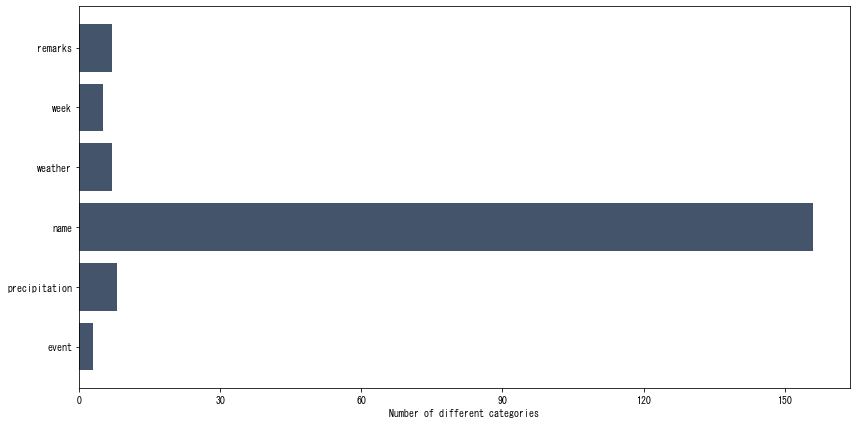

In [44]:
# plot number of categories per categorical variable
fig, ax = plt.subplots(figsize=(12, 6))
color = [68/255,84/255,106/255]

variables = ['remarks', 'week', 'weather', 'name', 'precipitation', 'event']
numbers = [len(training_set[i].unique()) for i in variables]
ax.barh(variables, numbers, align='center', color=color)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of different categories', fontsize=10)
#ax.set_yticklabels(variables, fontdict={'fontsize':10})
ax.set_xticks(range(0,180,30))
ax.set_xticklabels(range(0,180,30), fontdict={'fontsize':10})

plt.tight_layout()

# Save the figure
#fig.savefig(output_dir + "cardinality.eps")


## Correlation between Different Dependent Variables

Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other.
So we need to find out if any pair of variables is highly correlated.

<AxesSubplot:>

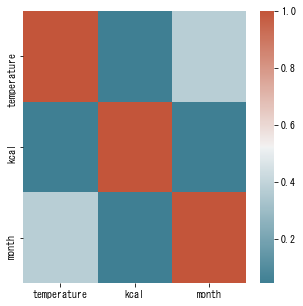

In [46]:
# Plot a correlation map
corrmat = training_set[['temperature', 'kcal', 'month']].corr(method='pearson')
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# some more parameters for the figure
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

# and now plot the correlation matrix
sns.heatmap(corrmat.abs(), cmap=cmap)

In [47]:
# Check correlation values of temperature and month
pearson_coef, p_value = stats.pearsonr(training_set['temperature'], training_set['month'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.3705917254659127  with a P-value of P = 3.8724317380318946e-08


The correlation between ```temperature``` and ```month``` is statistically significant, we need to perform feature selection when using these variables.

## Conclusion

[1] The dataset contains multiple variables of different types, i.e. numerical, categorical, and datetime variables.

[2] There are missing values, outliers, skewness, and non-normal distribution in the dataset.

[3] The linear correlation between ```sales``` and ```temperature``` is statistically significant.

[4] Some categorical variables (such as ```remarks```) can potentially be used as an indicator.

[5] ```name``` show high cardinality.

